In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
df1 = pd.read_csv("../dataset/cleaned_final_df.csv")

In [4]:
df2 = pd.read_csv("../dataset/cleaned_final_df_2025.csv")

In [8]:
merged_df = pd.concat([df1, df2], ignore_index=True)

In [9]:
merged_df.head()

,sex,viloyat_id,tuman_id,mfy_id,client_type,job_name,salary,total_client_family_salary,occupation_status,family_status,family_members_count,home_type,home_owner,client_monthly_expenditure,product_price,final_produt_price,status
0,1,6,76,5781,1.000000,164,6.000000e+06,6.000000e+06,1.0,1,3.241977,1.758023,1.0,1.500000e+06,1.290699e+07,1.290699e+07,1
1,2,6,76,5800,1.000000,51,2.833542e+06,2.833542e+06,1.0,1,2.667084,1.777639,1.0,1.222361e+06,2.812244e+07,2.812244e+07,1
2,1,6,76,5757,1.175123,66,1.446525e+05,1.446525e+05,1.0,1,4.824877,2.000000,1.0,1.929951e+06,8.104190e+06,8.104190e+06,1
3,2,6,90,6167,1.000000,51,3.000000e+06,3.000000e+06,1.0,1,3.000000,1.000000,1.0,1.200000e+06,6.708000e+06,6.708000e+06,0
4,1,6,78,5888,1.000000,165,5.000000e+06,5.000000e+06,1.0,1,3.405153,1.000000,1.0,1.540515e+06,6.758969e+06,6.758969e+06,1


In [10]:
len(merged_df)

16666

In [11]:
merged_df.columns

Index(['sex', 'viloyat_id', 'tuman_id', 'mfy_id', 'client_type', 'job_name',
       'salary', 'total_client_family_salary', 'occupation_status',
       'family_status', 'family_members_count', 'home_type', 'home_owner',
       'client_monthly_expenditure', 'product_price', 'final_produt_price',
       'status'],
      dtype='object')

In [12]:
X = merged_df.drop(columns=['status'])
y = merged_df['status']     

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)


Best hyperparameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}


In [15]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)

In [16]:
# Evaluate
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Train Accuracy: 0.9555117435282016
Test Accuracy: 0.8094


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      2534
           1       0.81      0.80      0.80      2466

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000

Confusion Matrix:
 [[2085  449]
 [ 504 1962]]


In [18]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X, y, cv=10)  # 10-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.80923815 0.81403719 0.81403719 0.81343731 0.81523695 0.82003599
 0.79771909 0.81152461 0.83853541 0.80612245]
Mean cross-validation score: 0.8139924356065162


In [19]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X_train.columns,
                                   columns=["importance"]).sort_values("importance", ascending=False)
print(feature_importances)

                            importance
client_type                   0.215007
product_price                 0.123234
final_produt_price            0.112244
mfy_id                        0.102475
tuman_id                      0.067830
job_name                      0.062140
salary                        0.061790
total_client_family_salary    0.054981
family_members_count          0.051027
client_monthly_expenditure    0.050632
home_type                     0.038469
sex                           0.028776
viloyat_id                    0.016488
family_status                 0.006353
occupation_status             0.004706
home_owner                    0.003848


In [20]:
import pickle
model_name = '../model/merged_random_forest_model.pkl'
pickle.dump(rf, open(model_name, 'wb'))

In [21]:
from sklearn.metrics import roc_auc_score
y_pred_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


ROC AUC Score: 0.8925377237773898


In [22]:
from sklearn.metrics import roc_curve
# Compute the false positive rate (FPR) 
# and true positive rate (TPR) for different classification thresholds 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

In [23]:
# Compute the ROC AUC score 
roc_auc = roc_auc_score(y_test, y_pred_prob) 
roc_auc

0.8925377237773898

In [24]:
import matplotlib.pyplot as plt

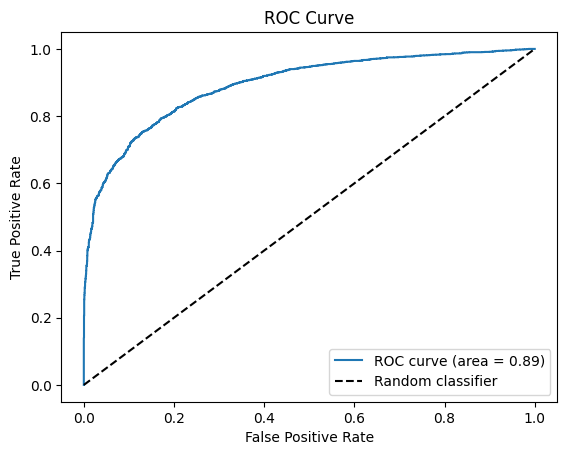

In [25]:
# Plot the ROC curve 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr 
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()
